# Simulation of Axonal Guidance

We simulate axon guidance to demonstrate that axons can use our proposed mechanism to navigate through the gene expression address space discovered in the [Hierarchy Decomposition notebook](./Hierarchy%20Decomposition.ipynb).

In [40]:
%load_ext autoreload
%autoreload 2

import json

import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import igraph
from tqdm import tqdm
import matplotlib.pyplot as plt
from pythreejs import *

from abianalysis.guidance.metrics import get_euclidean_distance
from abianalysis.volume.volume import VOXEL_SIZES
from pylineage.color import TreeColorMap

from guidance_experiment import SimulatedExperiment, DataExperiment
from guidance_plots import (distance_vs_path_length_plot,
                                    plot_reached_voxel_count_comparison,
                                    plot_path_length_comparison,
                                    plot_reached_distance_comparison,
                                    plot_correlation_distribution)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
global_params = dict(
    # The age at which to perform the navigation simulations.
    age='P28',
    
    # Number of iterations of hierarchical decomposition. Increasing
    # this number will greatly increase the memory footprint of the 
    # guidance simulation.
    n_iterations=32,
    
    # 50 is for testing; for real analysis change to 1000+
    n_sources=50,  
    
    # Any correlation under 0.1 is considered to be unmeasurable
    landscape_threshold=.1,
    
    # Any gradient can be measured
    gradient_threshold=.0,
    
    # This is the normal method as described in the paper
    split_method='pca'
)

In [38]:
experimental = DataExperiment(**global_params,
                         label='Experimental')
experimental.prepare()
experimental.sample_axons()

# We store the source voxels, and use the same voxel sources for all
# guidance simulations. This makes them comparable.
axon_sources = [experimental.guidance_graph.get_voxel_index(v) 
                for v in experimental.sources]
random_axons = list(experimental.random_fake_axons())

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.25it/s]


In [41]:
axons = experimental.axons
positions = experimental.volume.voxel_indices.astype(np.float32)
center = tuple(-np.mean(positions, axis=0))
cmap = TreeColorMap().get_color_map(experimental.hierarchy)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(v * 255) for v in rgb)

cmap = {k: rgb_to_hex(v) for k, v in cmap.items()}

In [66]:
%%time
lines = [Line(
        geometry=BufferGeometry(attributes={
            'position': BufferAttribute(array=positions[line])
        }),
        material=LineBasicMaterial(color=cmap[axon.get_hierarchy(axon.source)], 
                                   linejoin='round'),
        position=center,
    ) for axon in axons for line in axon.branch_paths]

CPU times: user 50.3 s, sys: 1.76 s, total: 52.1 s
Wall time: 51.8 s


In [68]:
camera = PerspectiveCamera(position=[-60, 0, 0], up=[0, -1, 0], aspect=800/400, near=50)
Renderer(
    alpha=False,
    controls=[OrbitControls(controlling=camera, zoomSpeed=.1)],
    width=800,
    height=400,
    camera=camera,
    scene=Scene(children=[*lines], background='black')
)

Renderer(camera=PerspectiveCamera(aspect=2.0, near=50.0, position=(-60.0, 0.0, 0.0), projectionMatrix=(1.0, 0.…

In [4]:
noise10 = DataExperiment(**global_params, label='Noise10', noise_amount=.1)
noise10.prepare()
noise10.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.64it/s]


In [5]:
noise100 = DataExperiment(**global_params, label='Noise100', noise_amount=1.)
noise100.prepare()
noise100.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.54it/s]


In [6]:
noise30 = DataExperiment(**global_params, label='Noise30', noise_amount=.3)
noise30.prepare()
noise30.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


In [7]:
n_few_genes=100
few_genes = DataExperiment(**global_params,
                           label='Few genes',
                           genes=np.random.choice(2027, size=n_few_genes, replace=False))
few_genes.prepare()
few_genes.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]


In [8]:
def dissimilarity_scores(ex1, ex2, axons=None):
    if axons is None:
        axons = ex2.axons
    ex1_pos = ex1.volume.voxel_indices
    ex2_pos = ex2.volume.voxel_indices
    ss = []
    for (_, e1), (_, e2) in zip(sorted((a.source_voxel, a) for a in ex1.axons), 
                                sorted((a.source_voxel, a) for a in axons)):
        d = cdist(ex1_pos[e1.tips], ex2_pos[e2.tips])
        m = (np.mean(np.min(d, 0)) + np.mean(np.min(d, 1))) / 2
        s = np.mean(m) / 5
        ss.append(s)
    return ss

In [9]:
exp_n10 = dissimilarity_scores(experimental, noise10)
exp_n30 = dissimilarity_scores(experimental, noise30)
exp_n100 = dissimilarity_scores(experimental, noise100)
exp_fg = dissimilarity_scores(experimental, few_genes)
exp_rnd = dissimilarity_scores(experimental, experimental, axons=random_axons)

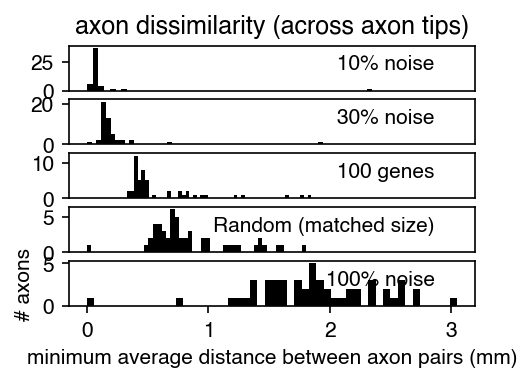

In [10]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 9}
import matplotlib
matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=5, sharex=True, dpi=150, figsize=(3.5, 2.3))

def plot_hist(ax, exp, label=None):
    ax.hist(exp, bins=50, color='k')
    ax.grid(False)
    ax.label_outer()
    ax.spines['bottom'].set_visible(True)
    plt.setp(ax.xaxis.get_major_ticks(), visible=False)
    if label is not None:
        ax.text(.9, .8, label, transform=ax.transAxes, ha='right', va='top')
    return ax

axs[0].set_title('axon dissimilarity (across axon tips)')

  
plot_hist(axs[0], exp_n10, label='10% noise')
plot_hist(axs[1], exp_n30, label='30% noise')
plot_hist(axs[2], exp_fg, label=f'{n_few_genes} genes')
plot_hist(axs[3], exp_rnd, label='Random (matched size)')
plot_hist(axs[4], exp_n100, label='100% noise')
plt.setp(axs[4].xaxis.get_major_ticks(), visible=True)
axs[4].set_ylabel('# axons')
axs[4].set_xlabel('minimum average distance between axon pairs (mm)')
fig.savefig('expanded_robustness.pdf', transparent=True)

Calculating path distances: 100%|███████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_14231/3591093876.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


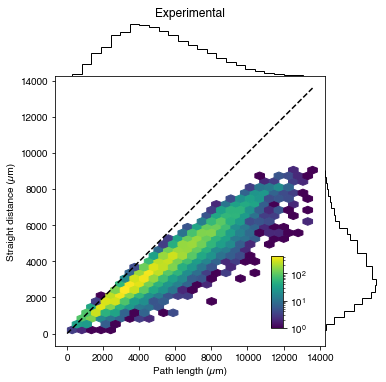

In [11]:
fig = distance_vs_path_length_plot(experimental, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_regular_p28.pdf')

Calculating path distances: 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12553.29it/s]


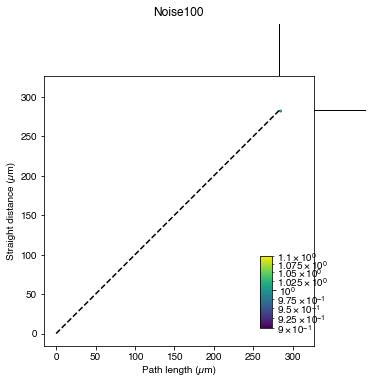

In [12]:
fig = distance_vs_path_length_plot(noise100, n_bins=25)
fig.savefig('sim_axons_regular_p28.pdf')

Calculating path distances: 100%|███████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_14231/3675581751.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


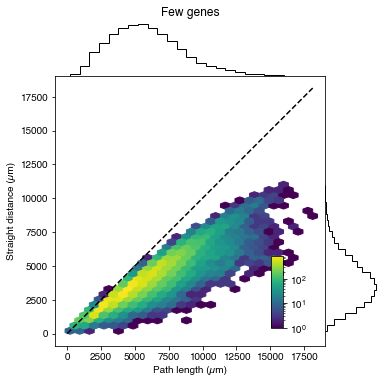

In [13]:
fig = distance_vs_path_length_plot(few_genes, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_few_genes_p28.pdf')

In [14]:
shuffled = DataExperiment(**global_params,
                          expression='shuffled',
                          label='Shuffled')
shuffled.prepare()
shuffled.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.23it/s]


Calculating path distances: 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12115.26it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_14231/1865379843.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


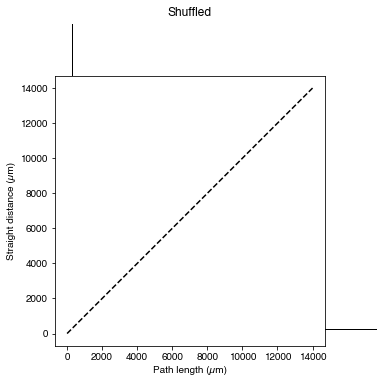

In [15]:
fig = distance_vs_path_length_plot(shuffled, n_bins=25, max_value=14000, colorbar=False)
fig.tight_layout()
fig.savefig('sim_axons_shuffled_p28.pdf')

In [16]:
simulated = SimulatedExperiment(**global_params,
                                n_voxels=experimental.volume.n_voxels,
                                label='Simulated')
simulated.prepare()
simulated.sample_axons()

Simulating volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.32it/s]


Calculating path distances: 100%|███████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.09it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_14231/250893111.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


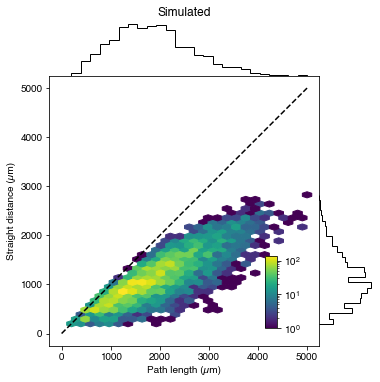

In [17]:
fig = distance_vs_path_length_plot(simulated, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_simulated_p28.pdf')

In [18]:
label_anatomies = [experimental.volume.anatomy[0].root.find(name) for name in [
    'dorsal pallium/isocortex',
    'ventral pallium',
    'medial pallium (hippocampal allocortex)',
    'striatum (corpus striatum)',
    'pallidum (globus pallidus complex)',
    'thalamus',
    'peduncular (caudal) hypothalamus',
    'rostral secondary prosencephalon',
    'midbrain',
    'pontine hindbrain',
    'medullary hindbrain (medulla)',
    'cerebellar vermis',
]]

In [19]:
def sort_voxels(voxels, roots=None):
    if roots is None:
        roots = [experimental.volume.anatomy[0].root]
        
    idx = {}
    i = 0
    for root in roots:
        for a in root.depth_first():
            if a not in idx:
                idx[a] = i
                i += 1
                
    anatomies = experimental.volume.anatomy[voxels]
    idx_list = np.array([idx[a] if a in idx else np.nan for a in anatomies])    
    s = np.argsort(idx_list)
    return voxels[s[~np.isnan(idx_list[s])]]


def get_sources_and_tips(axons):
    tips = np.array(list(set(tip for axon in axons for tip in axon.tips)))
    srcs = np.array(list(set([axon.source_voxel for axon in axons])))
    
    assert len(axons) == len(srcs), (
        'the number of sources must be the number of ' 
         'axons. Otherwise, at least one axon is sampled twice.')
    
    return srcs, tips

def get_matrix(axons, src, tips):
    source_idx = {s: i for i, s in enumerate(src)}
    tip_idx = {t: i for i, t in enumerate(tips)}

    matrix = np.zeros((len(src), len(tips)))
    for axon in axons:
        if axon.source_voxel in source_idx:
            i = source_idx[axon.source_voxel]
            for tip in axon.tips:
                if tip in tip_idx:
                    j = tip_idx[tip]
                    matrix[i, j] = 1
    return matrix

def ticks_and_labels(anatomies, label_anatomies):
    
    label_sets = [(frozenset(a.descendants()), a.name) 
                  for a in label_anatomies]
    
    labels = []
    for anatomy in anatomies:
        for s, label in label_sets:
            if anatomy in s:
                labels.append(label)    
                break
    labels = np.array(labels)
    
    ticks = [0, *np.nonzero(np.diff([hash(l) for l in labels]))[0] + 1]

    return ticks, labels[ticks]



In [20]:
all_sources, all_tips = get_sources_and_tips(experimental.axons)
all_sources = sort_voxels(all_sources, roots=label_anatomies)
all_tips = sort_voxels(all_tips, roots=label_anatomies)
matrix = get_matrix(experimental.axons, all_sources, all_tips)

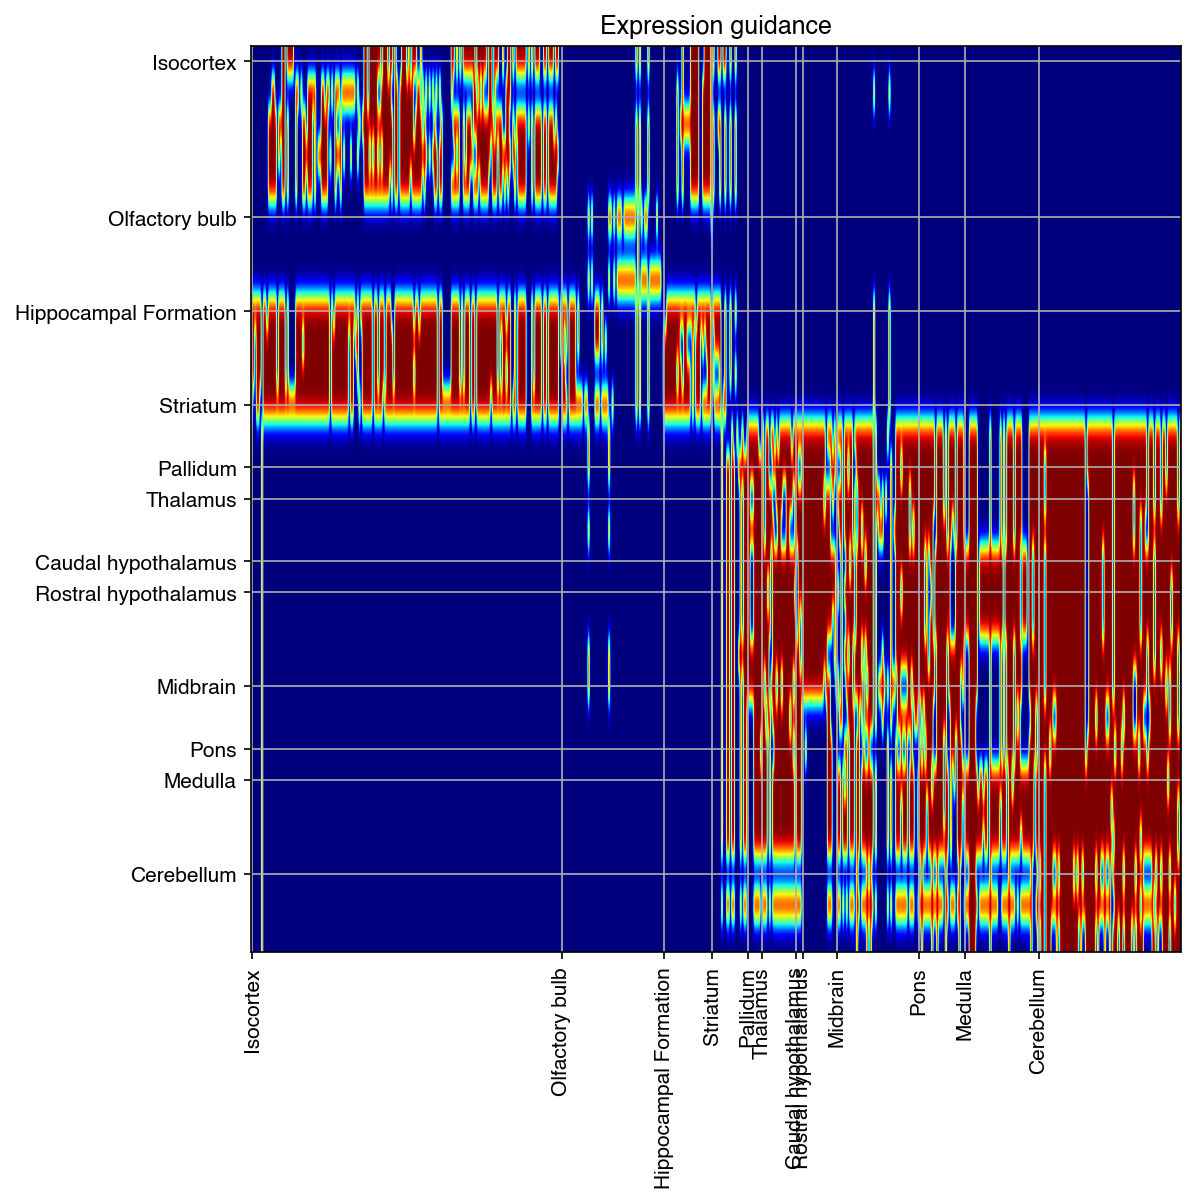

In [21]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

cmap = 'jet'
interpolation = 'gaussian'

x_ticks, x_labels = ticks_and_labels(
    experimental.volume.anatomy[all_tips],
    label_anatomies)

y_ticks, y_labels = ticks_and_labels(
    experimental.volume.anatomy[all_sources], 
    label_anatomies)

labels = ['Isocortex', 'Olfactory bulb', 'Hippocampal Formation',
          'Striatum', 'Pallidum', 'Thalamus', 'Caudal hypothalamus',
          'Rostral hypothalamus', 'Midbrain', 'Pons', 'Medulla',
          'Cerebellum'
         ]

ax.set_title('Expression guidance')
ax.imshow(matrix , 
          interpolation=interpolation, 
          cmap=cmap)
ax.set_aspect('auto')
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(y_ticks)
ax.set_yticklabels(labels)
ax.grid()

fig.savefig('sim_axons_matrix.pdf')